In [3625]:
import pandas as pd
import re
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [3626]:
def load_data(resume_path, info_path):
    resume = pd.read_excel(resume_path)
    info = pd.read_excel(info_path)
    df = pd.merge(resume, info, how="left", on="employee_code")
    df.columns = [remove_space(name) for name in df.columns.to_list()]
    return df

In [3627]:
def remove_space(text):
    text = re.sub(r'\s+$', '', text)
    text = re.sub(r'^\s+', '', text)
    return text

In [3628]:
def format_date(date):
    try:
        date = re.sub(r'\n', '', date)
        date = re.sub(r'\u200b', '', date)
        date = remove_space(date)
        date = re.sub("[Cc][Uu][Rr][Rr][Ee][Nn][Tt]", "Present", date)
        date = re.sub("[Pp][Rr][Ee][Ss][Ee][Nn][Tt]", "Present", date)
        date = re.sub("Ongoing", "Present", date)
        date = re.sub("[Nn][Oo][Ww]", "Present", date)
        date = re.sub("[Tt]ill [Dd]ate", "- Present", date)
        date = re.sub(r"\sto\s", " - ", date)
        date = re.sub(r"[Ff][Ee][Bb][Uu][Aa][Rr][Yy]", "February", date)
        date = re.sub(r"—", " - ", date)
        date = re.sub(r"–", " - ", date)
        date = re.sub(r"–", " - ", date)
        date = re.sub(r"[\’]", " ", date)
        date = re.sub(r"[0-9]{4}[\,]", " - ", date)
        date = re.sub(r"-", " - ", date)
        date = re.sub(r" -", " - ", date)
        date = re.sub(r"- ", " - ", date)
        date = re.sub(r"/", " ", date)
        date = re.sub(r"([0-9]+)(\syear[s]*)", " - ", date)
        date = re.sub(r"([0-9]+)(\s[Mm]onth[s]*.*)", " - ", date)
        date = re.sub(r"\s+", " ", date)
        date = re.sub(r"(.*)\s18", r"\1 2018", date)
        date = re.sub(r"(.*)\s12", r"\1 2012", date)
        date = re.sub(r"(.*)\s15", r"\1 2015", date)
        date = re.sub(r"(.*)\s16", r"\1 2016", date)
        date = re.sub(r"(.*)\s14", r"\1 2014", date)
        return date
    except TypeError:
        return " - "

In [3629]:
# format all
def format_all(df, colname_lst):
    for colname in colname_lst:
        resume_incl_hire[colname] = resume_incl_hire[colname].apply(format_date)
    return df

In [3630]:
def calculate_num_month(start_date, end_date):
    try:
        num_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
        return num_months
    except TypeError:
        return "unknown"

In [3631]:
def work_length_calculater(df, colname, hire):
    start = df[colname].str.split(" - ", expand=True)[0]
    end = df[colname].str.split(" - ", expand=True)[1]
    hire = df[hire]
    new = pd.concat([end, hire], axis=1).rename(columns = {1: "end"})
    new.end = new.apply(lambda row: row["Hire Date"] if "Present" in row['end'] else row["end"], axis=1)
    new = pd.concat([new, start], axis=1).rename(columns = {0: "start"})
    new.end = pd.to_datetime(new.end)
    new.start = pd.to_datetime(new.start)
    new["num_month"] = new.apply(lambda row: calculate_num_month(row.start, row.end), axis=1)
    df = new[["start", "end", "num_month"]]
    return df

In [3632]:
def avg_work_calculater(df, colname_lst, hire):
    work1 = work_length_calculater(df, column_lst[0], "Hire Date")["num_month"]
    work2 = work_length_calculater(df, column_lst[1], "Hire Date")["num_month"]
    work3 = work_length_calculater(df, column_lst[2], "Hire Date")["num_month"]
    work4 = work_length_calculater(df, column_lst[3], "Hire Date")["num_month"]
    work5 = work_length_calculater(df, column_lst[4], "Hire Date")["num_month"]
    work6 = work_length_calculater(df, column_lst[5], "Hire Date")["num_month"]
    work7 = work_length_calculater(df, column_lst[6], "Hire Date")["num_month"]
    df_all = pd.concat([work1, work2, work3, work4, work5, work6, work7], axis=1)
    df_all.columns = ["work1", "work2", "work3", "work4", "work5", "work6", "work7"]
    #df_all['num'] = df_all.count(axis=1)
    #df_all['total'] = df_all.sum(axis=1)
    df_all['avg'] = (df_all.sum(axis=1)/df_all.count(axis=1)).round(2)
    return df_all

In [3633]:
def job_hopper(num):
    if pd.isna(num):
        return np.nan
    elif num < 12:
        return 1
    else:
        return 0

In [3634]:
# run 
path1 = "../data/05242020_manual_extraction_template.xlsx"
path2 = "../data/matching_list_maunually-checked_V1.2.xlsx"
column_lst = ["work1_time", "work2_time", "work3_time", "work4_time", "work5_time", "work6_time", "work7_time"]
resume_incl_hire = load_data(path1, path2)
resume_incl_hire2 = format_all(resume_incl_hire, column_lst)
df_final = avg_work_calculater(resume_incl_hire2, column_lst, "Hire Date")
df_final["employee_code"] = resume_incl_hire.employee_code
df_final = df_final[["employee_code", "work1", "work2", "work3", "work4", "work5", "work6", "work7", "avg"]]
#df_final["avg_group"] = pd.cut(df_final.avg, 5)

### Job Hopper definition – Anyone with less than one year of tenure between jobs.

In [3635]:
# Add a column `job_hopper`
df_final["job_hopper"] = df_final.avg.apply(job_hopper)

In [3636]:
df_final.head()

,employee_code,work1,work2,work3,work4,work5,work6,work7,avg,job_hopper
0,BDP,44.0,63.0,36.0,NaN,NaN,NaN,NaN,47.67,0.0
1,F6Q,NaN,22.0,NaN,NaN,NaN,NaN,NaN,22.00,0.0
2,MRN,24.0,24.0,NaN,NaN,NaN,NaN,NaN,24.00,0.0
3,MXO,54.0,21.0,7.0,26.0,NaN,NaN,NaN,27.00,0.0
4,N0Y,4.0,14.0,19.0,8.0,NaN,NaN,NaN,11.25,1.0


In [3637]:
pd.value_counts(df_final.job_hopper)

0.0    216
1.0     66
Name: job_hopper, dtype: int64

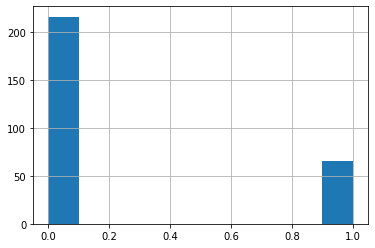

In [3638]:
df_final.job_hopper.hist()

In [3639]:
df_final.to_csv("../result/avg_work_exp.csv", index=False)